In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_tukey_spectrum_amplitude
from positioning.sound_db import TukeyDB
from positioning import tools

In [3]:
# sns.set(style="whitegrid")
plt.style.use(["science", "notebook"])

In [4]:
db = TukeyDB("../data/reference-phone-tukey")

In [5]:
true_pos = pd.read_csv("../data/pos-phone-agc-off/true_positions.csv", index_col=0)

In [6]:
true_pos

,x,y
test0,-0.6,0.9
test1,-0.6,1.2
test2,-0.6,1.5
test3,-0.6,1.8
test4,-0.3,0.9
test5,-0.3,1.2
test6,-0.3,1.5
test7,-0.3,1.8
test8,0.0,0.9
test9,0.0,1.2


In [7]:
est_poses = []
est_polars = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/pos-phone-agc-off/test{i}.wav")[:, 1]
    err = []
    pos = []
    polar = []
    for j in range(100):
        est_polar = np.ravel(
            db.positioning(test_signal[j * 96000 : (j + 2) * 96000], output="polar")
        )
        est_pos = tools.polar_to_rect(est_polar[1], np.radians(est_polar[0]))
        pos.append(est_pos)
        polar.append(est_polar)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    est_polars.append(polar)
    errors.append(err)

In [8]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["azimuth"] = np.array(est_polars[i])[:, 0]
    df_est_pos["distance"] = np.array(est_polars[i])[:, 1]
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])
df_est.reset_index(inplace=True, drop=True)

In [9]:
df_est.head()

,x,y,azimuth,distance,error,test_position
0,-0.481381,0.638814,-37.0,0.799882,0.286860,test0
1,-0.481381,0.638814,-37.0,0.799882,0.286860,test0
2,-0.511868,0.679272,-37.0,0.850540,0.237673,test0
3,-0.511481,0.678759,-37.0,0.849898,0.238293,test0
4,-0.507295,0.673203,-37.0,0.842941,0.245012,test0


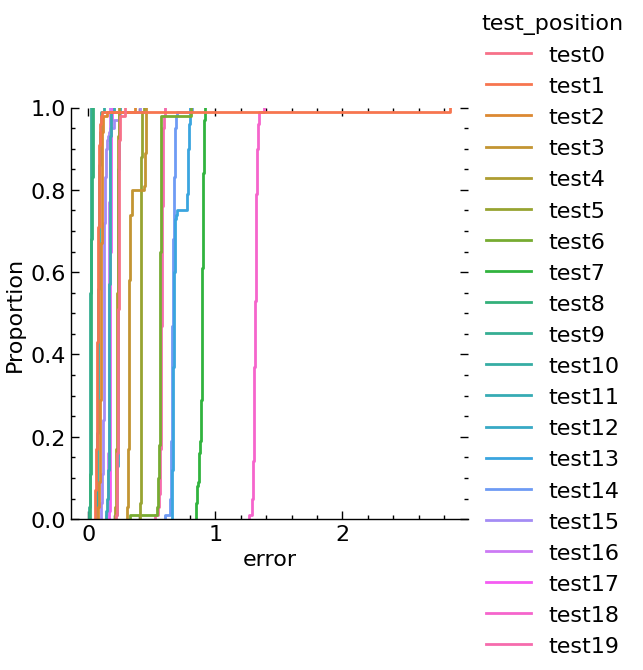

In [10]:
sns.displot(df_est, x="error", hue="test_position", kind="ecdf")

Text(9.444444444444445, 0.5, 'CDF')

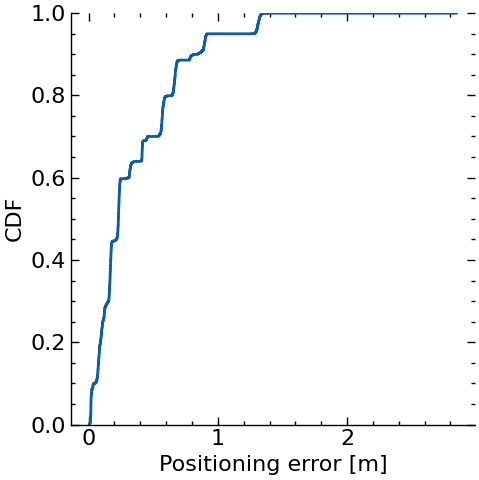

In [24]:
sns.displot(df_est, x="error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

In [12]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.2+ KB


/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_31791/2238469347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions.loc[:, "true_or_test"] = "test"


(0.0, 2.0)

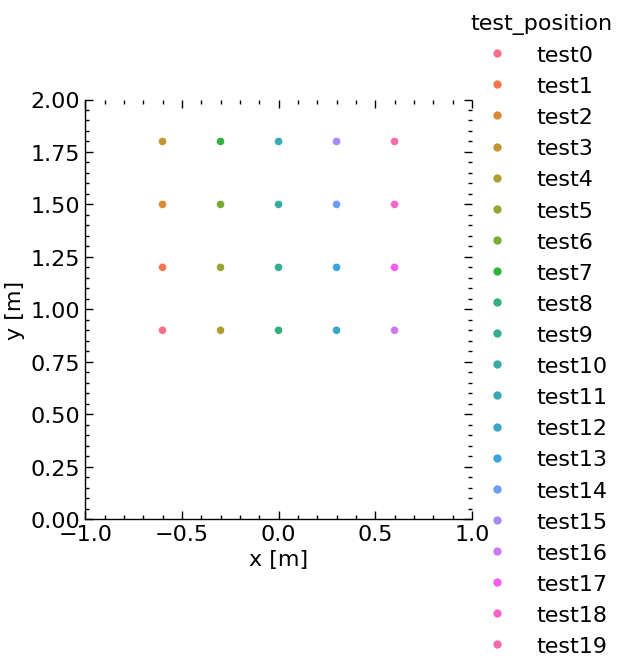

In [13]:
ax = sns.relplot(
    df_positions[df_positions["true_or_test"] == "true"],
    x="x",
    y="y",
    hue="test_position",
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(-1, 1)
plt.ylim(0, 2)

Text(9.569444444444445, 0.5, 'y [m]')

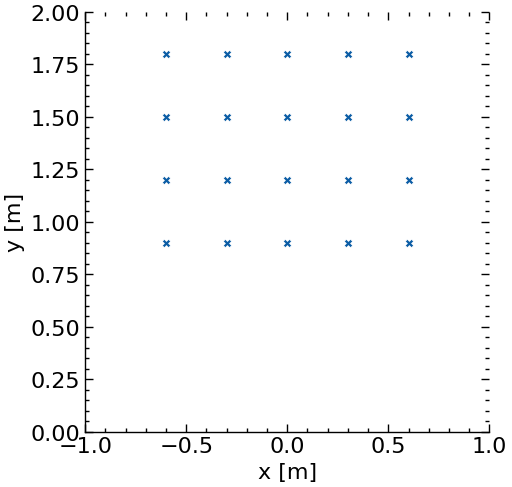

In [14]:
sns.relplot(
    df_positions[df_positions["true_or_test"] == "true"], x="x", y="y", marker="X"
)
plt.xlim(-1, 1)
plt.ylim(0, 2)
plt.xlabel("x [m]")
plt.ylabel("y [m]")

Text(70.94722916666666, 0.5, 'y [m]')

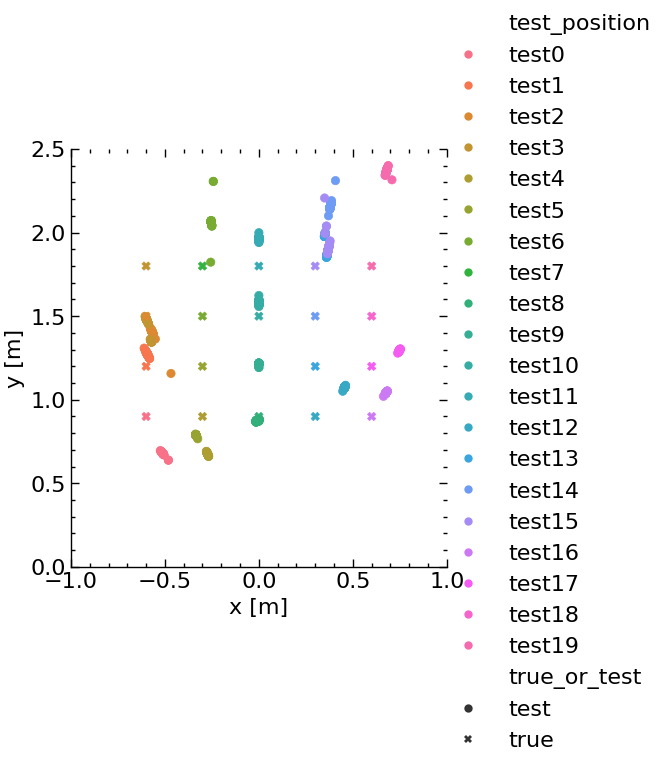

In [15]:
ax = sns.relplot(
    df_positions, x="x", y="y", hue="test_position", style="true_or_test", ec="face"
)
plt.xlim(-1, 1)
plt.ylim(0, 2.5)
plt.xlabel("x [m]")
plt.ylabel("y [m]")

Text(70.94722916666666, 0.5, 'y [m]')

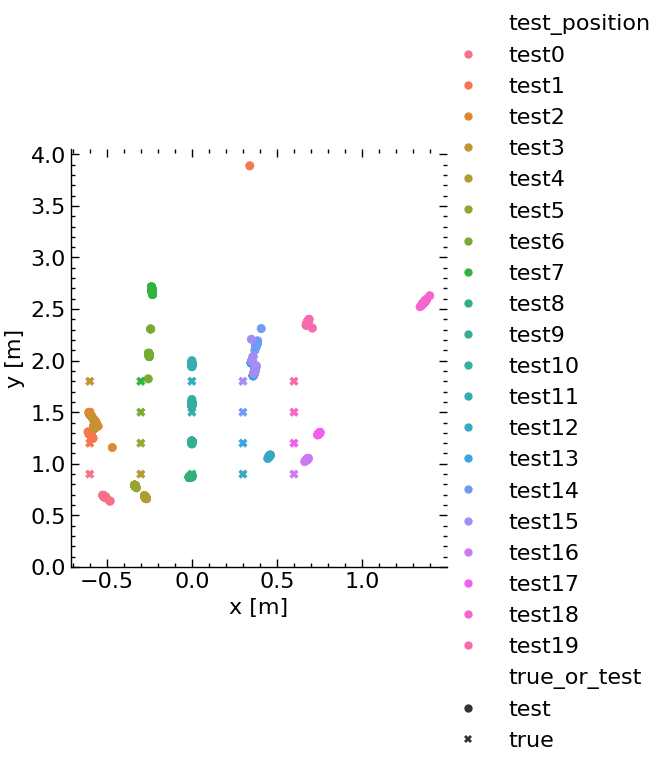

In [16]:
ax = sns.relplot(
    df_positions,
    x="x",
    y="y",
    hue="test_position",
    style="true_or_test",
    ec="face",
)
plt.ylim(bottom=0)
plt.xlabel("x [m]")
plt.ylabel("y [m]")

In [17]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,0.236990,0.244105
1,test1,0.073714,0.086700
2,test2,0.099590,0.107679
3,test3,0.322717,0.450314
4,test4,0.228601,0.235152
5,test5,0.414243,0.418158
6,test6,0.565851,0.571455
7,test7,0.895689,0.907254
8,test8,0.021526,0.033708
9,test9,0.016445,0.018211


In [18]:
print(np.percentile(df_est["error"], 90))

0.8436807100714147


In [19]:
true_distance, true_azimuth = tools.rect_to_polar(true_pos["x"], true_pos["y"])
true_pos["distance"] = true_distance
true_pos["azimuth"] = true_azimuth
true_pos.head()

,x,y,test_position,true_or_test,distance,azimuth
test0,-0.6,0.9,test0,true,1.081665,-33.690068
test1,-0.6,1.2,test1,true,1.341641,-26.565051
test2,-0.6,1.5,test2,true,1.615549,-21.801409
test3,-0.6,1.8,test3,true,1.897367,-18.434949
test4,-0.3,0.9,test4,true,0.948683,-18.434949


In [20]:
df_polar = df_est[["distance", "azimuth", "test_position"]]
df_polar.loc[:, "true_or_test"] = "test"
df_polar = pd.concat(
    [
        df_polar,
        true_pos[["distance", "azimuth", "test_position", "true_or_test"]],
    ]
)
df_polar.reset_index(drop=True, inplace=True)
df_polar.head()
true_pos.rename(columns={"azimuth": "true_azimuth"}, inplace=True)
df_polar = pd.merge(
    df_polar, true_pos[["test_position", "true_azimuth"]], on="test_position"
)
df_polar["azimuth_error"] = np.abs(df_polar["azimuth"] - df_polar["true_azimuth"])
df_polar.head()

/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_31791/2744435699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polar.loc[:, "true_or_test"] = "test"


,distance,azimuth,test_position,true_or_test,true_azimuth,azimuth_error
0,0.799882,-37.0,test0,test,-33.690068,3.309932
1,0.799882,-37.0,test0,test,-33.690068,3.309932
2,0.850540,-37.0,test0,test,-33.690068,3.309932
3,0.849898,-37.0,test0,test,-33.690068,3.309932
4,0.842941,-37.0,test0,test,-33.690068,3.309932


In [21]:
print(np.percentile(df_polar["azimuth_error"], 90))

5.309932474020213


Text(9.444444444444445, 0.5, 'CDF')

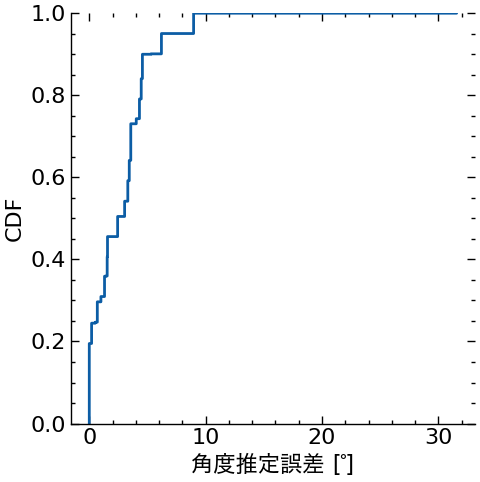

In [22]:
sns.displot(df_polar, x="azimuth_error", kind="ecdf")
plt.xlabel("角度推定誤差 [°]", fontname="Hiragino Sans")
plt.ylabel("CDF")

Text(27.149235339506177, 0.5, 'CDF')

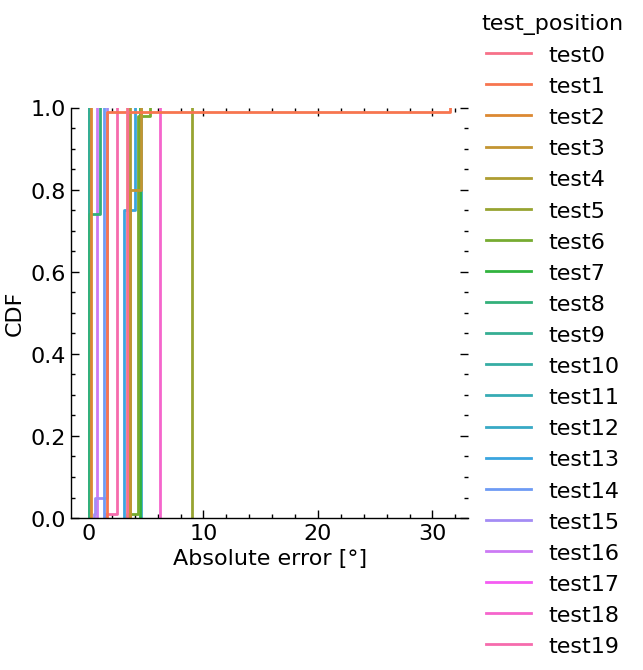

In [23]:
ax = sns.displot(
    df_polar[df_polar["true_or_test"] == "test"],
    x="azimuth_error",
    hue="test_position",
    kind="ecdf",
)
plt.xlabel("Absolute error [°]")
plt.ylabel("CDF")